In [1]:
# Install required packages
%pip install -q numpy matplotlib tensorflow keras pydot
%reset -f

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import required packages
import os
import random

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.utils import to_categorical, plot_model
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

import matplotlib.pyplot as plt


In [3]:
# Load tabular dataset 
datafile = '~/Downloads/csd.csv'
df = pd.read_csv(datafile)

# Trim unused columns
df_trimmed = df.loc[:, ~df.columns.isin(['feature', 'grade', 'stage'])] 
print(df_trimmed.shape)
df_trimmed.head()

(243, 16379)


,age,gender,OS_vital_status,CNV_20q,CNV_20p,CNV_Xq11.2,CNV_14q,CNV_17q24.3,CNV_7q36.3,CNV_12p,...,mRNA_PMS2L2|5380,mRNA_LRRC69|100130742,mRNA_GALNT4|8693,mRNA_OR11H12|440153,mRNA_C12orf50|160419,mRNA_TP53TG5|27296,mRNA_WDR48|57599,mRNA_UNC93A|54346,mRNA_ZNF20|7568,mRNA_PRR24|255783
0,54,FEMALE,1,0.000,0.000,-0.052984,-0.382,0.018996,0.003521,0.000,...,18.8615,1.4509,545.7878,0.0000,0.3627,0.6674,611.9120,8.7053,109.5203,286.5504
1,63,FEMALE,0,0.000,0.000,-0.029994,0.000,-0.010951,-0.000970,0.000,...,40.5490,0.8507,514.2375,0.0000,0.2836,0.8819,568.5363,132.1386,74.8341,72.8747
2,54,MALE,0,0.000,0.000,-0.010232,0.000,0.002358,-0.000416,0.000,...,22.5615,0.0000,460.2424,0.0000,0.3772,0.0000,806.8737,39.6081,101.9928,267.8262
3,65,MALE,1,0.000,0.000,-0.098945,-0.500,0.008892,0.066372,0.000,...,44.7036,1.9436,630.3401,0.0000,0.0000,0.0000,856.8189,5.1830,135.7953,129.5756
4,57,MALE,0,0.455,0.455,0.007262,0.000,0.002080,0.447990,0.438,...,46.1332,1.5268,665.6661,0.4325,0.4325,0.0000,767.3010,3.0277,112.4308,127.5952


In [4]:
# Split dataset into features and outcomes
features = df_trimmed.drop('OS_vital_status', axis = 1)
outcome = df_trimmed['OS_vital_status']

In [5]:
# Find categorical columns
cat_cols = features.select_dtypes(include = ['object']).columns
cat_cols

Index(['gender'], dtype='object')

In [6]:
# Convert categorical predictors to dummy variables
features['gender'].value_counts()
features = pd.get_dummies(features, columns = cat_cols, drop_first = True)
print(features.shape)
features.head(10)

(243, 16378)


,age,CNV_20q,CNV_20p,CNV_Xq11.2,CNV_14q,CNV_17q24.3,CNV_7q36.3,CNV_12p,CNV_12q,CNV_7q,...,mRNA_LRRC69|100130742,mRNA_GALNT4|8693,mRNA_OR11H12|440153,mRNA_C12orf50|160419,mRNA_TP53TG5|27296,mRNA_WDR48|57599,mRNA_UNC93A|54346,mRNA_ZNF20|7568,mRNA_PRR24|255783,gender_MALE
0,54,0.000,0.000,-0.052984,-0.382,0.018996,0.003521,0.000,0.000,0.000,...,1.4509,545.7878,0.0000,0.3627,0.6674,611.9120,8.7053,109.5203,286.5504,False
1,63,0.000,0.000,-0.029994,0.000,-0.010951,-0.000970,0.000,0.000,0.000,...,0.8507,514.2375,0.0000,0.2836,0.8819,568.5363,132.1386,74.8341,72.8747,False
2,54,0.000,0.000,-0.010232,0.000,0.002358,-0.000416,0.000,0.000,0.000,...,0.0000,460.2424,0.0000,0.3772,0.0000,806.8737,39.6081,101.9928,267.8262,True
3,65,0.000,0.000,-0.098945,-0.500,0.008892,0.066372,0.000,0.000,0.000,...,1.9436,630.3401,0.0000,0.0000,0.0000,856.8189,5.1830,135.7953,129.5756,True
4,57,0.455,0.455,0.007262,0.000,0.002080,0.447990,0.438,0.438,0.448,...,1.5268,665.6661,0.4325,0.4325,0.0000,767.3010,3.0277,112.4308,127.5952,True
5,63,0.486,0.486,0.047507,0.000,0.505190,0.535440,0.539,0.539,0.536,...,0.6558,1236.3735,0.0000,0.0000,0.0000,1317.4850,116.4030,95.5587,63.2839,True
6,61,0.000,0.000,-0.037021,-0.380,0.009728,0.008753,0.000,0.000,0.000,...,0.9984,639.9468,0.0000,0.3328,0.0000,868.6247,0.3328,125.9373,89.5249,False
7,46,0.000,0.000,-0.047124,0.000,-0.023018,0.007778,0.000,0.000,0.000,...,2.1461,510.1923,0.0000,0.0000,2.9652,569.0781,2.5038,134.8440,172.7622,True
8,60,0.210,0.210,-0.009681,0.000,0.010842,0.095508,0.000,0.000,0.000,...,1.4370,362.6488,0.0000,0.0000,0.9149,665.7885,163.8127,102.5698,408.5738,True
9,66,0.000,0.000,-0.003304,0.000,0.035100,0.000000,0.000,0.000,0.000,...,5.5698,494.4302,0.0000,0.0000,0.0000,577.9777,87.4036,81.6324,165.3813,False


In [7]:
# Convert binary outcome to dummy variables
outcome = pd.get_dummies(outcome, drop_first = True)
outcome

,1
0,True
1,False
2,False
3,True
4,False
...,...
238,False
239,True
240,False
241,False


In [8]:
# Convert to numpy arrays
features = features.values
print(features.shape)
outcome = outcome.values
print(outcome.shape)

(243, 16378)
(243, 1)


In [9]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(features, outcome, random_state = 42, test_size = 0.2)

In [10]:
# Apply scaler to features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [11]:
# Define keras model

def get_model():
    # Input layer defines shape by number of columns in the feature training set
    input_layer = Input(shape = (X_train.shape[1],))

    # Three dense layers with ReLu activation
    x = Dense(128, activation = 'relu')(input_layer)
    x = Dense(64, activation = 'relu')(input_layer)
    x = Dense(32, activation = 'relu')(input_layer)

    # Output layer using a signmoid activiation function for binary outcome
    output_layer = Dense(1, activation = 'sigmoid')(x)

    # Create model
    model = Model(inputs = input_layer, outputs = output_layer)

    # Compile model
    model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate =  0.0001), metrics = ['accuracy'])

    return model


In [12]:
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16378)]           0         
                                                                 
 dense_2 (Dense)             (None, 32)                524128    
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 524161 (2.00 MB)
Trainable params: 524161 (2.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
history = model.fit(X_train, y_train, batch_size = 16, epochs = 100, validation_split = 0.2, shuffle = True, verbose = 1)

Epoch 1/100
10/10 [==============================] - 0s 10ms/step - loss: 0.6725 - accuracy: 0.7355 - val_loss: 0.7750 - val_accuracy: 0.6923
Epoch 2/100
10/10 [==============================] - 0s 3ms/step - loss: 0.3085 - accuracy: 0.8903 - val_loss: 0.6346 - val_accuracy: 0.6923
Epoch 3/100
10/10 [==============================] - 0s 3ms/step - loss: 0.1807 - accuracy: 0.9548 - val_loss: 0.5903 - val_accuracy: 0.6923
Epoch 4/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0969 - accuracy: 0.9806 - val_loss: 0.5965 - val_accuracy: 0.6923
Epoch 5/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0682 - accuracy: 1.0000 - val_loss: 0.6092 - val_accuracy: 0.7179
Epoch 6/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0509 - accuracy: 1.0000 - val_loss: 0.6249 - val_accuracy: 0.7436
Epoch 7/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0403 - accuracy: 1.0000 - val_loss: 0.6290 - val_accuracy: 0.7179
Epoch 8/100


/Users/sohashahidi/DATASCI 223/datasci223_finalproj/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sohashahidi/DATASCI 223/datasci223_finalproj/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sohashahidi/DATASCI 223/datasci223_finalproj/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/User

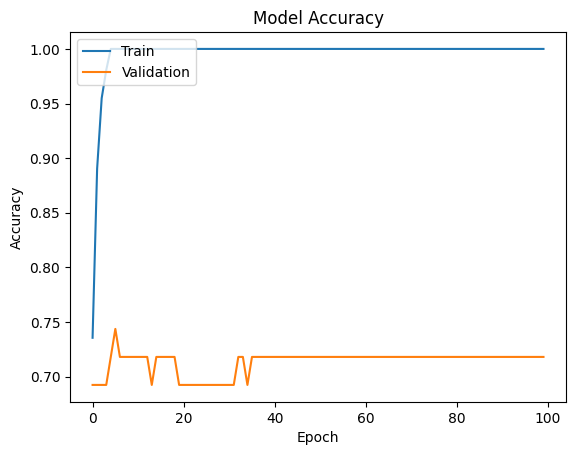

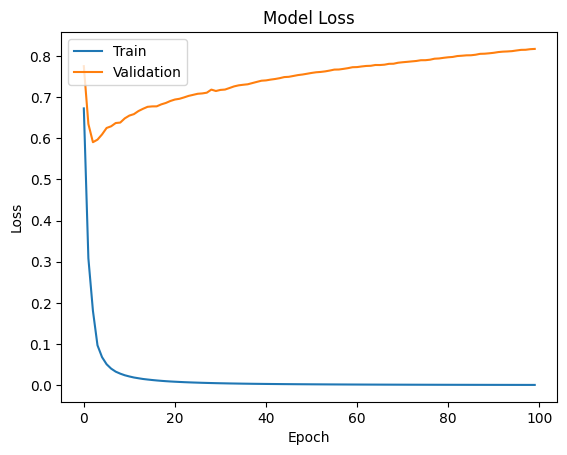

In [14]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

In [15]:
history = model.fit(X_train, y_train, batch_size = 16, epochs = 20, validation_split = 0.2, shuffle = True, verbose = 1)

Epoch 1/20
10/10 [==============================] - 0s 5ms/step - loss: 6.7288e-04 - accuracy: 1.0000 - val_loss: 0.8187 - val_accuracy: 0.7179
Epoch 2/20
10/10 [==============================] - 0s 3ms/step - loss: 6.6127e-04 - accuracy: 1.0000 - val_loss: 0.8196 - val_accuracy: 0.7179
Epoch 3/20
10/10 [==============================] - 0s 3ms/step - loss: 6.4988e-04 - accuracy: 1.0000 - val_loss: 0.8210 - val_accuracy: 0.7179
Epoch 4/20
10/10 [==============================] - 0s 3ms/step - loss: 6.3911e-04 - accuracy: 1.0000 - val_loss: 0.8217 - val_accuracy: 0.7179
Epoch 5/20
10/10 [==============================] - 0s 3ms/step - loss: 6.2828e-04 - accuracy: 1.0000 - val_loss: 0.8230 - val_accuracy: 0.7179
Epoch 6/20
10/10 [==============================] - 0s 3ms/step - loss: 6.1712e-04 - accuracy: 1.0000 - val_loss: 0.8239 - val_accuracy: 0.7179
Epoch 7/20
10/10 [==============================] - 0s 3ms/step - loss: 6.0681e-04 - accuracy: 1.0000 - val_loss: 0.8249 - val_accuracy:

In [19]:
# Predictions

y_pred = model.predict(X_test)
threshold = 0.5
y_pred = np.where(y_pred > threshold, 1, 0)

print(classification_report(y_test, y_pred, target_names = ['Alive', 'Died']))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

2/2 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       Alive       0.67      0.96      0.79        27
        Died       0.90      0.41      0.56        22

    accuracy                           0.71        49
   macro avg       0.78      0.69      0.68        49
weighted avg       0.77      0.71      0.69        49

Accuracy: 0.7142857142857143


/Users/sohashahidi/DATASCI 223/datasci223_finalproj/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sohashahidi/DATASCI 223/datasci223_finalproj/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sohashahidi/DATASCI 223/datasci223_finalproj/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/User

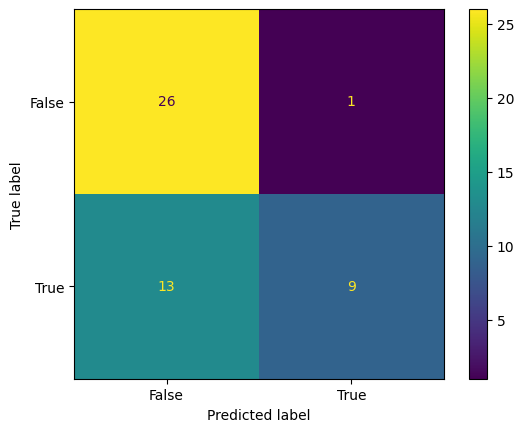

In [21]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)